##  0. Install and import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    706      0 --:--:-- --:--:-- --:--:--   706
100  404k  100  404k    0     0  1085k      0 --:--:-- --:--:-- --:--:-- 1085k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-wr1h7wh0
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-wr1h7wh0
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 636 kB 15.0 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.4.0-cp37-cp37m-linux_x86_64.whl size=24555992 sha256=2b3328b28af819c79e910d8da1abdde56a3d92ad0f709501ca738afda258cb3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ys9p371q/wheels/4c/03/f0/326bb241eb86a155a12f217c81e16

In [2]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

## 1. Load the Obj

We will load an obj file and create a **Meshes** object. **Meshes** is a unique datastructure provided in PyTorch3D for working with **batches of meshes of different sizes**. It has several useful class methods which are used in the rendering pipeline. 

If you are running this notebook locally after cloning the PyTorch3D repository, the mesh will already be available. **If using Google Colab, fetch the mesh and save it at the path `data/`**:

In [3]:
!mkdir -p data
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-07-27 20:10:44--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1606 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-07-27 20:10:45 (28.8 MB/s) - ‘plot_image_grid.py’ saved [1606/1606]



In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "Tile_+1984_+2690_groundtruth_L1.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [7]:
from math import cos,sin,pi
import numpy as np
from pytorch3d.transforms import axis_angle_to_matrix
# Initialize a camera.

T = torch.Tensor([6033.444325201213,4562.423854339868,14.7]).view([1,3]);


theta1 = -8 / 180 * pi    # pitch
theta2 = 90 / 180 * pi    # yaw
theta3 = 0 / 180 * pi     # roll

R = axis_angle_to_matrix(torch.Tensor([theta1,theta2,theta3]))
TR = torch.Tensor([[0,0,1],[1,0,0],[0,1,0]])
R = torch.matmul(TR,R)

R = R.view([1,3,3])
T = -torch.matmul(T,R).squeeze(0)
#T = -torch.matmul(R.transpose(1, 2), T.transpose(0,1)).squeeze(2)


print(T.shape)


#cameras = PerspectiveCameras(device=device, focal_length=((125,300),), principal_point=((200.0, 320.0),), image_size=((400,640),), R=R, T=T)
cameras = FoVPerspectiveCameras(device=device, fov=90.0, aspect_ratio=640/400., R=R, T=T)
print(cameras)
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# fov=90.0, aspect_ratio=640/400. FoVPerspectiveCameras
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=(400,640), 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, ambient_color=((0.8, 0.8, 0.8), ))

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

torch.Size([1, 3])
FoVPerspectiveCameras()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


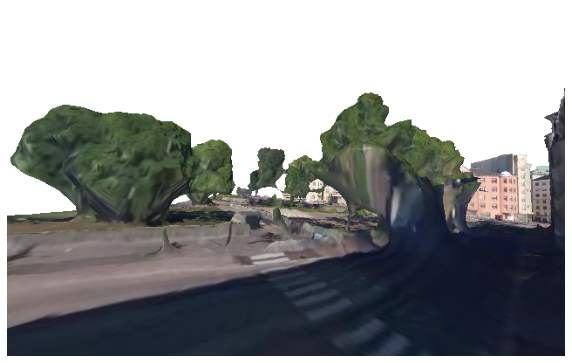

In [8]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

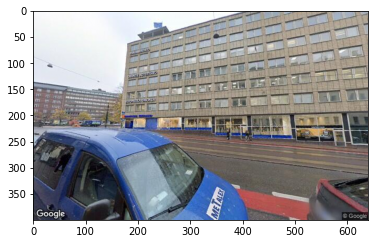

In [ ]:
import cv2
image_ref = cv2.resize(cv2.imread('data/ref.jpg'),(640,400))
image_ref = cv2.cvtColor(image_ref,cv2.COLOR_BGR2RGB) / 255.
plt.imshow(image_ref)